In [2]:
import openai
import os

In [3]:
from openai.embeddings_utils import cosine_similarity, get_embedding

In [4]:
# 获取访问open ai的密钥
openai.api_key = 'OPENAI_API_KEY'

# 选择模型
EMBEDDING_MODEL = "text-embedding-ada-002"

In [5]:
# 获取好评和差评
positive_review = get_embedding('好评')
negative_review = get_embedding('差评')

positive_example = get_embedding('买的银色版真的很好看，一天就到了，晚上就开始拿起来完系统很丝滑流畅，做工扎实，手感细腻，很精致哦苹果一如既往的好品质')
negative_example = get_embedding("降价厉害，保价不合理，不推荐")

In [6]:
def get_score(sample_embedding):
    return cosine_similarity(sample_embedding, positive_review) - cosine_similarity(sample_embedding, negative_review)

positive_score = get_score(positive_example)
negative_score = get_score(negative_example)

print("好评例子的评分： %f" % positive_score)
print("差评例子的评分： %f" % negative_score)

好评例子的评分： 0.070963
差评例子的评分： -0.072895


In [7]:

good_restraurant = get_embedding("这家餐馆太好吃了，一点都不糟糕")
bad_restraurant = get_embedding("这家餐馆太糟糕了，一点都不好吃")

good_score = get_score(good_restraurant)
bad_score = get_score(bad_restraurant)
print("好评餐馆的评分 : %f" % (good_score))
print("差评餐馆的评分 : %f" % (bad_score))

好评餐馆的评分 : 0.062719
差评餐馆的评分 : -0.074591


In [18]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

datafile_path = './data/fine_food_reviews_with_embeddings_1k.csv'

df = pd.read_csv(datafile_path)
df['embedding'] = df.embedding.apply(eval).apply(np.array)

# 将五星评级转换为二元情绪
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4:"positive", 5:"positive"})

              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



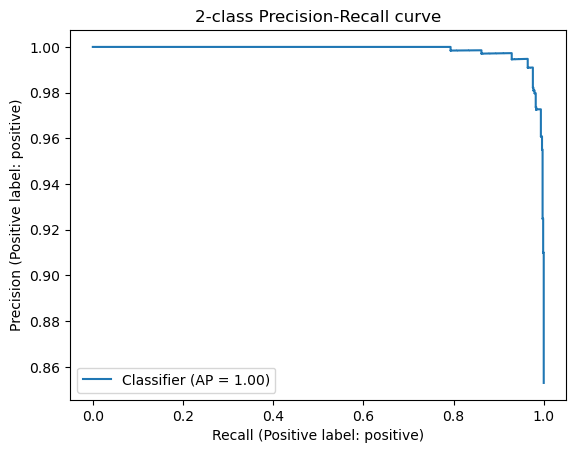

In [19]:
from sklearn.metrics import PrecisionRecallDisplay

def evaluate_embeddings_approach(
    labels = ['negative', 'positive'], 
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, engine=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])